# FINAL HOMEWORK - Francesca Zorzi
## 1 — Introduction
The result of mod(YOUR_STUDENT_ID_NUMBER, 3) + 1 is:


In [ ]:
(2157563 % 3) + 1

## 2 — Setup definition


In [1]:
from acados_template import AcadosModel, AcadosOcp, AcadosOcpSolver, AcadosSim, AcadosSimSolver
import casadi as ca
import numpy as np
from scipy.linalg import block_diag
from utils import piecewise_constant, plot_results, plot_pred_traj, plot_cpt, plot_grid, inverted_pendulum_animation
from tqdm import tqdm

# to make the figures interactive
import matplotlib
%matplotlib widget
import matplotlib.pyplot as plt

# to visualize videos in the notebook
from IPython.display import Video

### 3.1 — Encoding the system model
Then, we need to encode the continuous time model of our system into an `AcadosModel` object. This will be used both for the design of the Nonlinear MPC controller and to simulate the system. 

Notice that we will use [CasADi](https://web.casadi.org) symbolic variables (`casadi.SX.sym`) in the definition of the model: this will make possible automatic differentiation to compute sensitivities.

In [2]:
def get_inverted_pendulum_model(M = 1, m = 0.1, l = 0.8, g = 9.81)-> AcadosModel:
    
    #set model name
    model_name = "inverted_pendulum"

    #the physical parameters of the system are passed as parameters
    # g - gravity acceleration [m/s**2]
    # M - cart mass [kg]
    # m - pendulum mass [kg]
    # l - pendulum length [m]
 
    # setup states and controls symbolic variables
    p     = ca.SX.sym('p', 1, 1)
    theta = ca.SX.sym('theta', 1, 1)
    v     = ca.SX.sym('v', 1, 1)
    omega = ca.SX.sym('omega', 1, 1)

    x = ca.vertcat(p, theta, v, omega)
    u = ca.SX.sym('u', 1, 1)

    # setup symbolic variables for xdot (to be used with IRK integrator)
    p_dot     = ca.SX.sym('p_dot', 1, 1)
    theta_dot = ca.SX.sym('theta_dot', 1, 1)
    v_dot     = ca.SX.sym('v_dot', 1, 1)
    omega_dot = ca.SX.sym('omega_dot', 1, 1)

    xdot = ca.vertcat(p_dot, theta_dot, v_dot, omega_dot)

    # define dynamics
    a = -m*l*ca.sin(theta)*omega**2+m*g*ca.cos(theta)*ca.sin(theta)+u
    b = -m*l*ca.cos(theta)*ca.sin(theta)*omega**2+u*ca.cos(theta)+(M+m)*g*ca.sin(theta)
    c = M+m-m*(ca.cos(theta))**2
    
    # explicit ODE right hand side (to be used with ERK integrator)
    f_expl = ca.vertcat(v, 
                        omega, 
                        a/c,
                        b/(l*c))

    # implicit dynamics (to be used with IRK integrator)
    f_impl = xdot - f_expl

    # create acados model and fill in all the required fields
    model = AcadosModel()

    model.f_impl_expr = f_impl
    model.f_expl_expr = f_expl
    model.x = x
    model.xdot = xdot
    model.u = u
    model.name = model_name

    return model

## [Task 1] Including the input rate in the formulation

In [4]:
def get_extended_inverted_pendulum_model(M = 1, m = 0.1, l = 0.8, g = 9.81)-> AcadosModel:
    
    #set model name
    model_name = "extended_inverted_pendulum"

    #the physical parameters of the system are passed as parameters
    # g - gravity acceleration [m/s**2]
    # M - cart mass [kg]
    # m - pendulum mass [kg]
    # l - pendulum length [m]
 
    # setup states and controls symbolic variables
    p     = ca.SX.sym('p', 1, 1)
    theta = ca.SX.sym('theta', 1, 1)
    v     = ca.SX.sym('v', 1, 1)
    omega = ca.SX.sym('omega', 1, 1)
    F     = ca.SX.sym('F', 1, 1)  # additional state: force applied to the cart

    x = ca.vertcat(p, theta, v, omega, F)
    dF = ca.SX.sym('dF')
    u = dF

    # setup symbolic variables for xdot (to be used with IRK integrator)
    p_dot     = ca.SX.sym('p_dot', 1, 1)
    theta_dot = ca.SX.sym('theta_dot', 1, 1)
    v_dot     = ca.SX.sym('v_dot', 1, 1)
    omega_dot = ca.SX.sym('omega_dot', 1, 1)
    xF_dot    = ca.SX.sym('F_dot', 1, 1)  # derivative of the additional state

    xdot = ca.vertcat(p_dot, theta_dot, v_dot, omega_dot, xF_dot)

    # define dynamics
    a = -m*l*ca.sin(theta)*omega**2 + m*g*ca.cos(theta)*ca.sin(theta) + F
    b = -m*l*ca.cos(theta)*ca.sin(theta)*omega**2 + F*ca.cos(theta) + (M+m)*g*ca.sin(theta)
    c = M+m-m*(ca.cos(theta))**2
    
    # explicit ODE right hand side (to be used with ERK integrator)
    f_expl = ca.vertcat(v, 
                        omega, 
                        a/c,
                        b/(l*c),
                        dF)

    # implicit dynamics (to be used with IRK integrator)
    f_impl = xdot - f_expl

    # create acados model and fill in all the required fields
    model = AcadosModel()

    model.f_impl_expr = f_impl
    model.f_expl_expr = f_expl
    model.x = x
    model.xdot = xdot
    model.u = u
    model.name = model_name

    return model

In [5]:
def create_ocp_solver_description(model, N, T, x0) -> AcadosOcp:
    # create ocp object to formulate the OCP
    ocp = AcadosOcp()

    # define system dynamics model
    ocp.model = model

    # set prediction horizon
    ocp.solver_options.tf = T
    ocp.solver_options.N_horizon = N

    # get state, control and cost dimensions
    # Nota: Assumiamo che 'model' sia già quello esteso (5 stati, 1 input)
    nx = model.x.rows() # Ora è 5: [p, theta, v, omega, F]
    nu = model.u.rows() # Ora è 1: [dF]

    ny = nx + nu 
    ny_e = nx
   
    # define cost type
    ocp.cost.cost_type = 'LINEAR_LS'
    ocp.cost.cost_type_e = 'LINEAR_LS'

    # define cost weigth matrices
    Q_diag = [10, 10, 0.1, 0.1, 0.01]
    #Q_diag = [1.0, 500.0, 0.1, 0.1, 0.001] 
    Q = np.diag(Q_diag)
    R_diag = [0.01] 
    R = np.diag(R_diag)
    
    ocp.cost.W = block_diag(Q, R)
    ocp.cost.W_e = T/N * Q  

    # define matrices characterizing the cost
    ocp.cost.Vx = np.vstack((np.eye(nx), np.zeros((nu, nx))))
    ocp.cost.Vu = np.vstack((np.zeros((nx, nu)), np.eye(nu)))
    ocp.cost.Vx_e = np.eye(nx)
    
    # initialize variables for reference
    ocp.cost.yref = np.zeros((ny,))
    ocp.cost.yref_e = np.zeros((ny_e,))

    # --- VINCOLI (Adattato per Task 1) ---
    
    # 1. Vincoli sugli INPUT (dF)
    # Qui limitiamo la derivata della forza. Se non specificato dal task,
    # mettiamo un valore alto per permettere variazioni rapide se necessario.
    #max_dF = 500.0
    #ocp.constraints.lbu = np.array([-max_dF])
    #ocp.constraints.ubu = np.array([max_dF])
    #ocp.constraints.idxbu = np.array([0])

    # 2. Vincoli sugli STATI (p, F)
    # Dobbiamo vincolare la Posizione (p) e la Forza (F).
    # p è indice 0, F è indice 4.
    
    # Limiti: p in [-2, 2] (esempio standard), F in [-20, 20] (limite attuatore)
    '''
    ocp.constraints.idxbx = np.array([0, 4])
    ocp.constraints.lbx = np.array([-2.0, -20.0]) # [p_min, F_min]
    ocp.constraints.ubx = np.array([ 2.0,  20.0]) # [p_max, F_max]
    '''

    ocp.constraints.idxbx = np.array([4]) # Solo l'indice 4 (F) è vincolato
    ocp.constraints.lbx = np.array([-20.0]) # Limite inferiore F
    ocp.constraints.ubx = np.array([ 20.0]) # Limite superiore F
    
    # initialize constraint on initial condition
    ocp.constraints.x0 = x0

    # set solver options
    ocp.solver_options.qp_solver = "PARTIAL_CONDENSING_HPIPM"
    ocp.solver_options.hessian_approx = "GAUSS_NEWTON"
    ocp.solver_options.integrator_type = "ERK"
    ocp.solver_options.nlp_solver_type = "SQP"
    
    ocp.solver_options.nlp_solver_max_iter = 100
    ocp.solver_options.qp_solver_iter_max = 50
    ocp.solver_options.qp_solver_warm_start = 0
    
    return ocp

Since we are going to run different simulations, we define the following function to clean the `AcadosSimSolver` and `AcadosOcpSolver` objects generated in previous executions. Indeed, while in Python such variables would be overwritten, this would not affect the generated and compiled C code which is then actually run.

In [5]:
def clear_previous_simulation():
    variables = globals().copy()
    for v in variables:
        if(type(variables[v]) is AcadosSimSolver or type(variables[v]) is AcadosOcpSolver):
            del globals()[v]

Additionally, we will use the following function to check the consistency of the time parameters (i.e., the simulation fundamental step size, the controller sample time and the simulation final time instant)

In [6]:
def compute_num_steps(ts_sim, Ts, Tf):
    # check consistency
    if(round(Ts % ts_sim) != 0):
        raise ValueError("The sample time Ts has to be an integer multiple of the simulation time step ts_sim")
    if(round(Tf % ts_sim) != 0):
        raise ValueError("The simulation time Tf has to be an integer multiple of the simulation time step ts_sim")

    # compute the number of simulation steps
    N_steps    = int(Tf/ts_sim)
    # compute the number of steps for the discrete-time part of the loop
    N_steps_dt = int(Tf/Ts)
    # number of simulation steps every which to update the discrete-time part of the loop 
    n_update   = int(Ts/ts_sim)

    return (N_steps, N_steps_dt, n_update)

In [8]:
# 1. Setup Simulazione (Plant "Reale")
# define simulation fundamental time step [s]
ts_sim = 0.001

# [IMPORTANTE] Il modello simulato è quello FISICO (4 stati: p, theta, v, omega)
# Non conosce lo stato "Forza", riceve direttamente la Forza come input.
sim_model = get_inverted_pendulum_model(l=0.8)

# initial condition (Plant): Pendolo giù [0, pi, 0, 0]
x0 = np.array([0, np.pi, 0, 0])

# 2. Setup Controller (Modello Esteso)
# - system model: [IMPORTANTE] Qui usiamo il modello ESTESO (5 stati: ..., F)
# Assumiamo che tu abbia la funzione definita precedentemente
model = get_extended_inverted_pendulum_model(l=0.8)

# - controller sample time [s]
Ts = 0.02  # 50 Hz
# - number of shooting time intervals 
N  = 150
#Ts = 0.05       # Un passo leggermente più lungo aiuta a guardare più lontano con meno nodi
#N  = 3.0/Ts         # N*Ts = 2.0 secondi (o N=50, Ts=0.04)
# - prediction horizon length [s]
#N = 50
#Ts = 2.0 / N  # Ts = 0.04 secondi
T = N * Ts # 2.0 secondi


# get state and control dimensions (nx=5, nu=1)
nx, nu = model.x.rows(), model.u.rows()

# 3. Definizione Riferimento (Swing-up)
# Il Task 1 richiede di portare il pendolo a [0,0,0,0] con F=0 e dF=0.
# Non usiamo più 'piecewise_constant' perché il target è fisso (Origine).

# Durata della simulazione [s] (Fissiamo noi, es. 5 secondi per lo swing-up)
Tf = 5.0 

# Calcolo passi simulazione
N_steps, N_steps_dt, n_update = compute_num_steps(ts_sim, Ts, Tf)

# Creazione y_ref
# Per il cost type LINEAR_LS, y_ref ha dimensione (nx + nu) = 6.
# Vogliamo: p=0, theta=0, v=0, omega=0, F=0 (stati) e dF=0 (input).
# Quindi creiamo una matrice di zeri.
# Lunghezza: passi discreti + N (per il look-ahead del controller all'ultimo step)
total_steps_ref = N_steps_dt + N + 1
y_ref = np.zeros((total_steps_ref, nx + nu))

# [Opzionale] Se volessi spostare il carrello a p=1 dopo lo swing-up, modificheresti qui.
# Ma per il Task 1 base (swing-up all'origine), tutti zeri è corretto.

# configure whether to apply shifting and to enable reference look-ahead
# Shifting: True è consigliato per RTI/SQP real-time, aiuta la convergenza inizializzando con la soluzione precedente shiftata.
shifting    = True 
ref_preview = False # False va bene dato che il riferimento è costante (0)

In [11]:
import os
import ctypes

# 1. Impostiamo il percorso base (fondamentale per togliere il Warning)
acados_path = "/Users/francescazorzi/acados"
os.environ["ACADOS_SOURCE_DIR"] = acados_path
os.environ["DYLD_LIBRARY_PATH"] = f"{acados_path}/lib"

# 2. Carichiamo MANUALMENTE le librerie che mancano
# Questo è il trucco: le carichiamo in memoria così Acados le trova già pronte
try:
    # Carica libblasfeo
    ctypes.CDLL(f"{acados_path}/lib/libblasfeo.dylib", mode=ctypes.RTLD_GLOBAL)
    # Carica libhpipm (quella che ti dava errore)
    ctypes.CDLL(f"{acados_path}/lib/libhpipm.dylib", mode=ctypes.RTLD_GLOBAL)
    print("✅ Librerie caricate manualmente con successo!")
except Exception as e:
    print(f"❌ Errore nel caricamento manuale: {e}")

# Ora importiamo Acados
from acados_template import AcadosSim, AcadosSimSolver, AcadosOcpSolver

✅ Librerie caricate manualmente con successo!


In [ ]:
# --- 1. Setup Simulazione (Plant Fisico - 4 Stati) ---
sim = AcadosSim()
sim.model = sim_model  # Modello a 4 stati
sim.solver_options.T = ts_sim
sim.solver_options.integrator_type = 'ERK'
acados_integrator = AcadosSimSolver(sim, verbose=False)

# --- 2. Setup Solver MPC (Modello Esteso - 5 Stati) ---
# Necessario estendere x0 con la forza iniziale (F=0) per l'inizializzazione
x0_mpc = np.hstack((x0, 0.0)) 

ocp = create_ocp_solver_description(model, N, T, x0_mpc)
acados_ocp_solver = AcadosOcpSolver(ocp, verbose=False)

# Recupero dimensioni corrette
nx_sim = sim_model.x.rows() # 4 (p, theta, v, omega)
nu_sim = sim_model.u.rows() # 1 (F)
nx_mpc = model.x.rows()     # 5 (..., F)
nu_mpc = model.u.rows()     # 1 (dF)

# Inizializzazione solver (guess iniziale)
for stage in range(N):
    acados_ocp_solver.set(stage, "x", x0_mpc)
    acados_ocp_solver.set(stage, "u", np.zeros((nu_mpc,)))
acados_ocp_solver.set(N, "x", x0_mpc)

# --- 3. Inizializzazione Variabili Log ---
k = 0

# simX: salva solo gli stati fisici
simX = np.zeros((N_steps + 1, nx_sim))
simX[0, :] = x0

# simU: salva l'input applicato al plant (Forza F)
simU = np.zeros((N_steps_dt, nu_sim))

# x_opt: salva la predizione MPC (stati estesi, incluso F)
x_opt = np.zeros((N+1, nx_mpc, N_steps_dt + 1))
x_opt[:, :, 0] = np.repeat(x0_mpc.reshape(1,-1), N+1, axis=0)

# u_opt: salva la predizione MPC (input dF)
u_opt = np.zeros((N, nu_mpc, N_steps_dt + 1))

# cpt: tempo di calcolo
cpt = np.zeros((N_steps_dt,))

# Variabile di stato aggiuntiva per integrare la forza
F_current = 0.0 

# --- 4. Ciclo di Simulazione ---
for i in tqdm(range(N_steps), desc="Simulation", ascii=False, ncols=75, colour='green'):

    # check whether to update the discrete-time part of the loop
    if(i % n_update == 0):
        '''
        # 4a. Update reference
        # Aggiornamento per gli stadi 0 a N-1
        for j in range(N):
            acados_ocp_solver.set(j, "yref", y_ref[k + (j if ref_preview else 0), :])
        
        # CORREZIONE: Aggiornamento per lo stadio terminale N
        # 1. Usiamo la chiave "yref" (l'unica accettata).
        # 2. Passiamo il vettore COMPLETO di dimensione 6 (non affettato a 5).
        #    L'interfaccia Python richiede dimensione piena (nx+nu), anche se acados userà solo i primi nx elementi.
        acados_ocp_solver.set(N, "yref", y_ref[k + (N if ref_preview else 0), :])
        '''
        # 4a. Update reference
        # Aggiornamento per gli stadi 0 a N-1 (Stati + Input -> dim 6)
        for j in range(N):
            acados_ocp_solver.set(j, "yref", y_ref[k + (j if ref_preview else 0), :])
        
        # CORREZIONE FINALE: Aggiornamento per lo stadio terminale N (Solo Stati -> dim 5)
        # L'errore dice "dimension 5 (you have 6)", quindi dobbiamo passare solo i primi 5 elementi.
        acados_ocp_solver.set(N, "yref", y_ref[k + (N if ref_preview else 0), :nx_mpc])

        # 4b. Shifting (Warm Start)
        if shifting:
            for stage in range(N):
                acados_ocp_solver.set(stage, "x", x_opt[stage+1, :, k])
                acados_ocp_solver.set(stage, "u", u_opt[min([stage+1,N-1]), :, k])
            acados_ocp_solver.set(N, "x", x_opt[N, :, k])
        
        # 4c. Costruzione stato esteso corrente
        # Uniamo lo stato fisico misurato (simX) con lo stato interno della Forza (F_current)
        current_x_mpc = np.hstack((simX[i, :], F_current))
        
        # 4d. Risoluzione OCP
        # solve_for_x0 imposta il vincolo x0, risolve e restituisce u[0] (che qui è dF!)
        dF_opt = acados_ocp_solver.solve_for_x0(current_x_mpc, 
                                                fail_on_nonzero_status=False,
                                                print_stats_on_failure=False)

        # Store CPU time
        cpt[k] = acados_ocp_solver.get_stats('time_tot')
        
        # 4e. Gestione Input Rate: Calcolo Forza da applicare
        # Salviamo la forza che applicheremo in questo intervallo (F_current)
        simU[k, :] = F_current
        
        # Aggiorniamo la forza per il PROSSIMO passo (integrazione di dF)
        # F_{k+1} = F_k + Ts * dF_opt
        F_current += dF_opt * Ts

        # 4f. Store optimal solution (logging)
        for stage in range(N):
            x_opt[stage, :, k+1] = acados_ocp_solver.get(stage, "x")
            u_opt[stage, :, k+1] = acados_ocp_solver.get(stage, "u")
        x_opt[N, :, k+1] = acados_ocp_solver.get(N, "x")
        
        k += 1
        
    # --- 5. Simula il sistema fisico ---
    # Usiamo simU[k-1] che contiene la Forza (F) corretta per il plant
    simX[i + 1, :] = acados_integrator.simulate(simX[i,:], simU[k-1, :])

In [ ]:
print("Average total CPU time: " + str(np.mean(cpt)*1000) + " ms")

time    = np.linspace(0, ts_sim * N_steps, N_steps + 1)
time_dt = np.linspace(0, Ts * (N_steps_dt-1), N_steps_dt)

matplotlib.pyplot.close('all')
plot_results(time, time_dt, simX, simU)
plot_cpt(time_dt, cpt, Ts)

In [ ]:
# 1. Trova l'indice correttamente
# Usa [0,0] per prendere il primo indice trovato ed essere sicuro di avere un intero
indices = np.argwhere(np.round(time_dt, 3) == 1)

if indices.size > 0:
    k_idx = indices[0, 0] # Estrae l'intero scalare
    
    # 2. Chiama la funzione passando l'intero k_idx
    # Nota: Assicurati che le dimensioni di x_opt/u_opt sliced siano coerenti con k_idx
    plot_pred_traj(time, time_dt, simX, simU, x_opt[:, :, 1:], u_opt[:, :, 1:], k_idx)
else:
    print("Errore: Il tempo t=5.0s non è stato trovato in time_dt. Verifica la durata della simulazione.")

In [13]:
#inverted_pendulum_animation(simX[:,0], simX[:, 1], ts_sim)

#Video("simulation.mp4", width=640, height=480)

## [TASK 2.3] Presence of model mismatch
We will now consider the case where the prediction model differs from the one used to simulate the
system dynamics, not only due to a different time step for integration, but also because of an actual
difference in their formulation.\
To achieve this, we will insert a mismatch in the parameters of the system. For example, you can
take as actual length of the pendulum $l_{true} = 0.9 m$, whereas the prediction model is written with
$l= 0.8 m$.\
Perform some tests with a mismatch commenting what happens in terms of control performances,
particularly analyzing the predicted trajectories.
Moreover, explore different tuning of the cost function and study what happens when changing the
prediction horizon length.\
$\textbf{Remark}$
In inserting the mismatch, make sure to give two different values to the field name of the AcadosModel
objects accounting for the simulation and the control models.

In [12]:
import shutil
import os
if os.path.exists('c_generated_code'):
    shutil.rmtree('c_generated_code')

In [13]:
import shutil
# --- 1. PULIZIA E SETUP INIZIALE ---
# Rimuove la cartella del codice generato per obbligare Acados a ricompilare
if os.path.exists('c_generated_code'):
    shutil.rmtree('c_generated_code')

# Parametri Globali
N = 80
T_horizon = 4.0
Ts = T_horizon / N
x0 = np.array([0.0, np.pi, 0.0, 0.0]) # Partenza: Pendolo giù

# --- 2. DEFINIZIONE DEI MODELLI (MISMATCH) ---

# A) Modello per il CONTROLLORE (Nominale, l=0.8m)
model_mpc = get_inverted_pendulum_model(l=0.8)
model_mpc.name = "pendulum_nominal_v2" 

# B) Modello per il SIMULATORE (Reale, l=0.9m -> Mismatch!)
model_sim = get_inverted_pendulum_model(l=0.8)
model_sim.name = "pendulum_real_mismatch"

print(f"Modello MPC: {model_mpc.name} (l=0.8)")
print(f"Modello SIM: {model_sim.name} (l=0.9)")

Modello MPC: pendulum_nominal_v2 (l=0.8)
Modello SIM: pendulum_real_mismatch (l=0.9)


In [14]:
# --- 3. FUNZIONE DI CONFIGURAZIONE OCP ---
def create_ocp_solver_description_task2(model, N, T_horizon, x0):
    ocp = AcadosOcp()
    ocp.model = model
    
    # Dimensioni
    nx = model.x.rows()
    nu = model.u.rows()
    ny = nx + nu
    ny_e = nx

    ocp.dims.N = N
    ocp.solver_options.tf = T_horizon

    # --- COSTI (Tuning Aggressivo per Swing-up) ---
    # Q: Penalizziamo molto Theta (50) per forzare la salita
    # R: Costo input BASSISSIMO (0.01) per dare potenza
    Q_mat = 2 * np.diag([10.0, 50.0, 0.1, 0.01]) 
    R_mat = 2 * np.diag([0.01])

    ocp.cost.cost_type = 'LINEAR_LS'
    ocp.cost.cost_type_e = 'LINEAR_LS'

    # Matrici Peso W
    ocp.cost.W = block_diag(Q_mat, R_mat)
    ocp.cost.W_e = Q_mat 

    # Matrici Vx, Vu
    ocp.cost.Vx = np.zeros((ny, nx))
    ocp.cost.Vx[:nx, :nx] = np.eye(nx)
    ocp.cost.Vu = np.zeros((ny, nu))
    ocp.cost.Vu[nx:, :] = np.eye(nu)
    ocp.cost.Vx_e = np.eye(nx)

    # Riferimenti (vogliamo andare a 0)
    ocp.cost.yref = np.zeros((ny,))
    ocp.cost.yref_e = np.zeros((ny_e,))

    # --- VINCOLI ---
    F_max = 20.0  # Forza alta per evitare saturazione immediata
    ocp.constraints.lbu = np.array([-F_max])
    ocp.constraints.ubu = np.array([+F_max])
    ocp.constraints.idxbu = np.array([0])
    ocp.constraints.x0 = x0

    # --- OPZIONI SOLVER ---
    ocp.solver_options.qp_solver = 'PARTIAL_CONDENSING_HPIPM'
    ocp.solver_options.hessian_approx = 'GAUSS_NEWTON'
    ocp.solver_options.integrator_type = 'ERK'
    ocp.solver_options.nlp_solver_type = 'SQP'
    ocp.solver_options.nlp_solver_max_iter = 100

    return ocp

In [ ]:
# --- 4. GENERAZIONE SOLVER E INTEGRATORE ---

# 4.1 Crea Descrizione OCP e Solver MPC (usando il modello nominale)
ocp_desc = create_ocp_solver_description_task2(model_mpc, N, T_horizon, x0)
acados_ocp_solver = AcadosOcpSolver(ocp_desc, json_file="acados_ocp_task2.json")

# 4.2 Crea Simulatore (usando il modello reale/mismatch)
sim = AcadosSim()
sim.model = model_sim
sim.solver_options.T = Ts # Passo di integrazione coerente con MPC
sim.solver_options.integrator_type = 'ERK'
sim.solver_options.num_stages = 4 
sim.solver_options.num_steps = 10
acados_integrator = AcadosSimSolver(sim, json_file="acados_sim_task2.json")

print("Generazione completata. Avvio simulazione...")

field AcadosOcpDims.N has been migrated to AcadosOcpOptions.N_horizon. setting AcadosOcpOptions.N_horizon = N. For future comppatibility, please use AcadosOcpOptions.N_horizon directly.
rm -f libacados_ocp_solver_pendulum_nominal_v2.dylib
rm -f acados_solver_pendulum_nominal_v2.o
cc -fPIC -std=c99   -O2 -I/Users/francescazorzi/acados/include -I/Users/francescazorzi/acados/include/acados -I/Users/francescazorzi/acados/include/blasfeo/include -I/Users/francescazorzi/acados/include/hpipm/include  -c -o acados_solver_pendulum_nominal_v2.o acados_solver_pendulum_nominal_v2.c
cc -fPIC -std=c99   -O2 -I/Users/francescazorzi/acados/include -I/Users/francescazorzi/acados/include/acados -I/Users/francescazorzi/acados/include/blasfeo/include -I/Users/francescazorzi/acados/include/hpipm/include  -c -o pendulum_nominal_v2_model/pendulum_nominal_v2_expl_ode_fun.o pendulum_nominal_v2_model/pendulum_nominal_v2_expl_ode_fun.c
cc -fPIC -std=c99   -O2 -I/Users/francescazorzi/acados/include -I/Users/franc

ld: warning: search path '-l' not found


acados was compiled without OpenMP.
cc -fPIC -std=c99   -O2 -I/Users/francescazorzi/acados/include -I/Users/francescazorzi/acados/include/acados -I/Users/francescazorzi/acados/include/blasfeo/include -I/Users/francescazorzi/acados/include/hpipm/include  -c -o acados_sim_solver_pendulum_real_mismatch.o acados_sim_solver_pendulum_real_mismatch.c
cc -fPIC -std=c99   -O2 -I/Users/francescazorzi/acados/include -I/Users/francescazorzi/acados/include/acados -I/Users/francescazorzi/acados/include/blasfeo/include -I/Users/francescazorzi/acados/include/hpipm/include  -c -o pendulum_real_mismatch_model/pendulum_real_mismatch_expl_ode_fun.o pendulum_real_mismatch_model/pendulum_real_mismatch_expl_ode_fun.c
cc -fPIC -std=c99   -O2 -I/Users/francescazorzi/acados/include -I/Users/francescazorzi/acados/include/acados -I/Users/francescazorzi/acados/include/blasfeo/include -I/Users/francescazorzi/acados/include/hpipm/include  -c -o pendulum_real_mismatch_model/pendulum_real_mismatch_expl_vde_forw.o pend

In [16]:
# --- 5. LOOP DI SIMULAZIONE ---

# Inizializzazione dati simulazione
Tf = 5.0
N_sim = int(Tf / Ts)

simX = np.zeros((N_sim+1, model_mpc.x.rows()))
simU = np.zeros((N_sim, model_mpc.u.rows()))
simX[0, :] = x0

# Matrici per salvare le predizioni (per i grafici Task 2.3)
predX = np.zeros((N+1, model_mpc.x.rows(), N_sim))
predU = np.zeros((N, model_mpc.u.rows(), N_sim))

for i in tqdm(range(N_sim)):
    
    # 1. Imposta il feedback (stato corrente) nel solver MPC
    acados_ocp_solver.set(0, "x", simX[i, :])
    
    # 2. Risolvi il problema di controllo ottimo
    status = acados_ocp_solver.solve()
    if status != 0:
        print(f"Warning: Solver failed at step {i} with status {status}")

    # 3. Estrai l'input ottimo
    u_opt = acados_ocp_solver.get(0, "u")
    simU[i, :] = u_opt
    
    # 4. SALVA LE PREDIZIONI (Cruciale per Task 2.3)
    for k in range(N+1):
        predX[k, :, i] = acados_ocp_solver.get(k, "x")
    for k in range(N):
        predU[k, :, i] = acados_ocp_solver.get(k, "u")

    # 5. Simula il sistema REALE (Modello Mismatch)
    simX[i+1, :] = acados_integrator.simulate(x=simX[i, :], u=u_opt)

100%|██████████| 80/80 [00:00<00:00, 86.90it/s]


Analisi predizione all'istante t = 1.50s


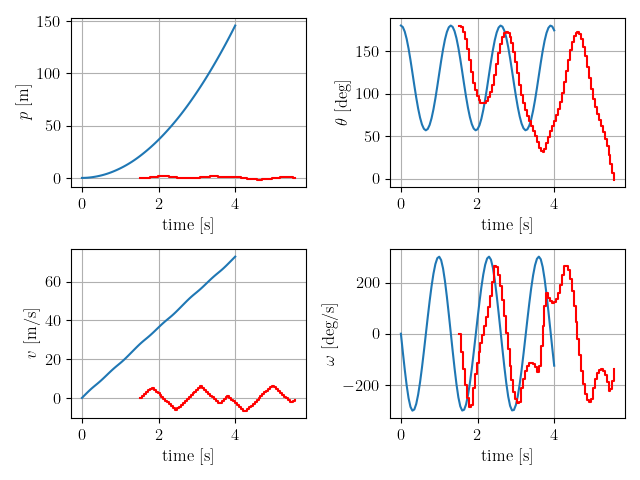

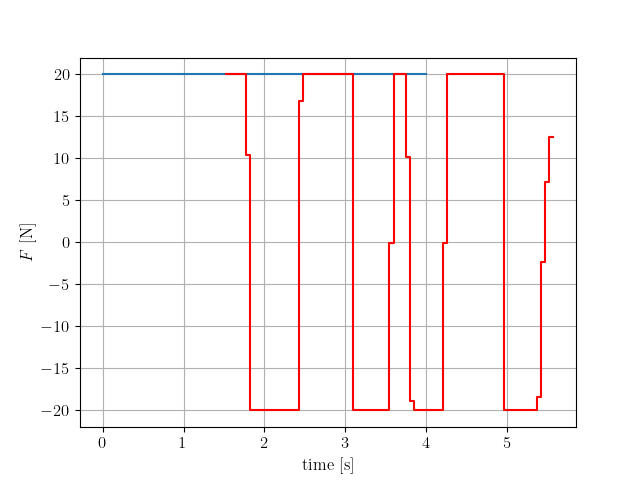

In [17]:
# --- 6. VISUALIZZAZIONE ---

# Creiamo i vettori tempo corretti
t_sim = np.linspace(0, Tf, N_sim+1) 
t_u = np.linspace(0, Tf, N_sim)     

# Scegli un istante k interessante (es. 1.5 secondi)
k_to_plot = int(1.5 / Ts) 
if k_to_plot >= N_sim: k_to_plot = N_sim - 1

print(f"Analisi predizione all'istante t = {t_sim[k_to_plot]:.2f}s")

# Plot finale con predizioni
plot_pred_traj(t_sim, t_u, simX, simU, predX, predU, k_to_plot)

In [76]:
#inverted_pendulum_animation(simX[:,0], simX[:, 1], Ts)

#Video("simulation.mp4", width=640, height=480)

In [18]:
print(f"Time Step Integratore: {sim.solver_options.T}")
print(f"Time Step MPC: {T_horizon / N}")

Time Step Integratore: 0.05
Time Step MPC: 0.05
